In [67]:
import os
import pprint

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

out_dir = "../../data/05_reporting/problem_set_2"

In [64]:
# helper functions

def load_data(fpath: str | os.PathLike = "../../data/01_raw/penguins.csv"
              ) -> pd.DataFrame:
    return pd.read_csv(fpath)

def plot_priors(model, n_prior_vals=100) -> None:
    plt_dict = {
        r'$\alpha$ prior': model.alpha_prior,
        r'$\beta$ prior': model.beta_prior,
        r'$\sigma$ prior': model.sigma_prior
    }

    fig, axs = plt.subplots(ncols=len(plt_dict), figsize=(15, 5))
    
    for (k, v), ax in zip(plt_dict.items(), axs):
        dist = v.rvs(n_prior_vals)
        labs = v.kwds
        ax.hist(dist, label=labs)
        ax.set_title(k)
        ax.legend()    



# Question 3

## 3.1

In [4]:
df = load_data()
df

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181,3750,MALE
1,Adelie,Torgersen,39.5,17.4,186,3800,FEMALE
2,Adelie,Torgersen,40.3,18.0,195,3250,FEMALE
3,Adelie,Torgersen,36.7,19.3,193,3450,FEMALE
4,Adelie,Torgersen,39.3,20.6,190,3650,MALE
...,...,...,...,...,...,...,...
337,Gentoo,Biscoe,47.2,13.7,214,4925,FEMALE
338,Gentoo,Biscoe,46.8,14.3,215,4850,FEMALE
339,Gentoo,Biscoe,50.4,15.7,222,5750,MALE
340,Gentoo,Biscoe,45.2,14.8,212,5200,FEMALE


In [5]:
our_penguin = "Gentoo"
gentoo = df[df['species'] == our_penguin]

## 3.2

In [30]:
class PenguinModel():

    def __init__(self):
        self.alpha_prior = self.assign_alpha_prior()
        self.beta_prior = self.assign_beta_prior()
        self.sigma_prior = self.assign_sigma_prior()
        self.likelihood = None

    # define model attributes
    def assign_alpha_prior(self, loc: float=3.0, scale: float=2.0):
        return sp.stats.norm(loc=loc, scale=scale)

    def assign_beta_prior(self, loc: float=0.1, scale: float=0.2):
        return sp.stats.norm(loc=loc, scale=scale)

    def assign_sigma_prior(self, s: float=1, scale: float=0):
        return sp.stats.lognorm(s=s, scale=np.exp(scale))


    def assign_likelihood(self, loc, scale):
        mod = sp.stats.norm(loc=loc, scale=scale)
        self.likelihood = mod

    # define methods
    def bootstrap(self, X, stat=np.mean, 
            random_state=np.random.default_rng()
    ) -> np.array:
        res = sp.stats.bootstrap(X, stat, random_state=random_state)
        return res.bootstrap_distribution
    
    def simulate_prior_predictive(self, X):
        X_hat = self.bootstrap((X, ))

        n_prior_samples = len(X_hat)

        alpha = self.alpha_prior.rvs(size=n_prior_samples)
        beta = self.beta_prior.rvs(size=n_prior_samples)
        sigma = self.sigma_prior.rvs(size=n_prior_samples)
        mu = alpha + beta * X_hat

        self.assign_likelihood(loc=mu, scale=sigma)
        y_tilde = self.likelihood.rvs(size=n_prior_samples)
        
        return y_tilde

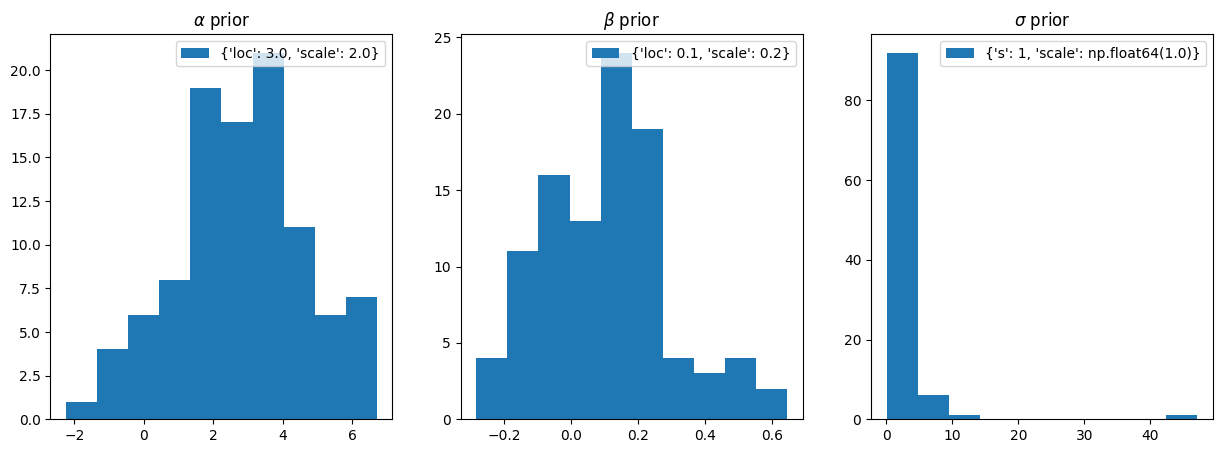

In [68]:
n_prior_vals = 100
model = PenguinModel()
plot_priors(model, n_prior_vals)
plt.savefig(os.path.join(out_dir, 'prior_distributions.pdf'), bbox_inches='tight')

In [62]:
pprint.pformat({'loc': 3.0, 'scale': 2.0})

"{'loc': 3.0, 'scale': 2.0}"

scipy.stats._distn_infrastructure.rv_continuous_frozen

In [55]:

model.alpha_prior.kwds

{'loc': 3.0, 'scale': 2.0}

(array([  10.,   56.,  417., 1315., 2673., 2952., 1848.,  600.,  119.,
           9.]),
 array([-149.61962806, -115.86005227,  -82.10047647,  -48.34090067,
         -14.58132488,   19.17825092,   52.93782671,   86.69740251,
         120.45697831,  154.2165541 ,  187.9761299 ]),
 <BarContainer object of 10 artists>)

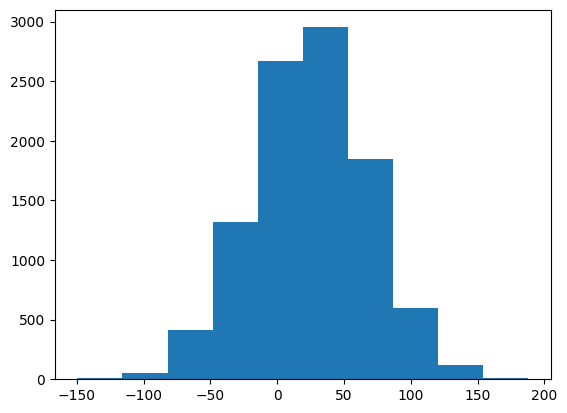

In [32]:
prior_predict = model.simulate_prior_predictive(gentoo['flipper_length_mm'])
plt.hist(prior_predict)

(array([3.000e+00, 2.500e+01, 2.130e+02, 1.058e+03, 2.444e+03, 3.165e+03,
        2.128e+03, 7.910e+02, 1.530e+02, 1.900e+01]),
 array([-167.18305258, -131.63379581,  -96.08453905,  -60.53528229,
         -24.98602552,   10.56323124,   46.112488  ,   81.66174477,
         117.21100153,  152.76025829,  188.30951506]),
 <BarContainer object of 10 artists>)

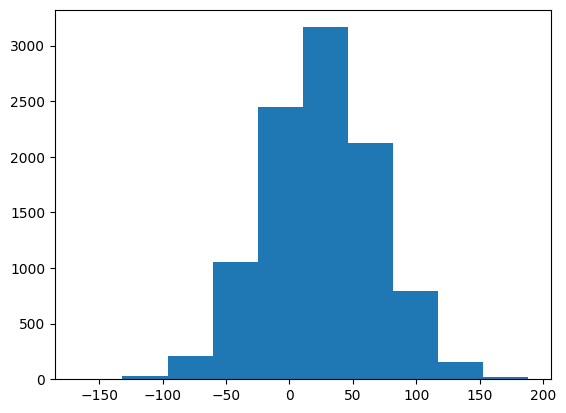

(array([1.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 1.0e+00, 1.0e+00,
        5.0e+00, 6.7e+01, 9.9e+03, 1.8e+01, 0.0e+00, 1.0e+00, 2.0e+00,
        1.0e+00, 1.0e+00, 0.0e+00, 1.0e+00]),
 array([-9791.67862174, -9189.49128594, -8587.30395013, -7985.11661433,
        -7382.92927852, -6780.74194272, -6178.55460691, -5576.36727111,
        -4974.1799353 , -4371.99259949, -3769.80526369, -3167.61792788,
        -2565.43059208, -1963.24325627, -1361.05592047,  -758.86858466,
         -156.68124885,   445.50608695,  1047.69342276,  1649.88075856,
         2252.06809437,  2854.25543017,  3456.44276598,  4058.63010178,
         4660.81743759,  5263.0047734 ]),
 <BarContainer object of 25 artists>)

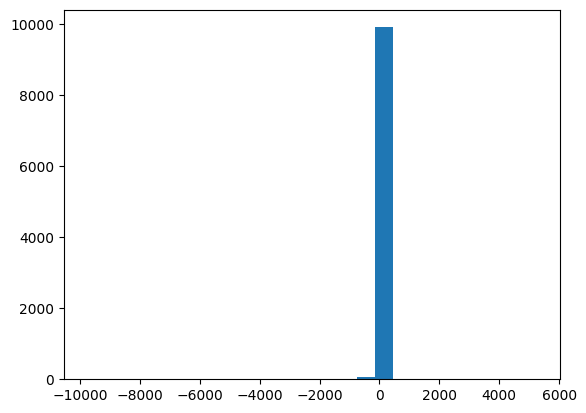

In [9]:
plt.hist(prior_predict[~np.isinf(prior_predict)], bins=25)